# Normalization Sandbox
This notebook is a test-bed for regularization and reconstruction methods

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt
import ndoperators as ops
import numpy as np

yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('float32')

## Load Data

In [17]:
# Define user for path setting
dataset_path = '/Users/zfphil/datasets/motiondeblur/'

# Define which dataset to use
dataset_type = 'coded'
dataset_label = 'res'

# Find files in this directory
folder_list = glob.glob(os.path.join(dataset_path, '*/'))
dataset_list = [folder for folder in folder_list if isDataset(folder)]

# Filter datasets in directory
filtered_dataset_list = [folder_name for folder_name in folder_list if (dataset_type in folder_name) and (dataset_label in folder_name)]
assert not len(filtered_dataset_list) > 1, "More than one dataset with criterion found!"
assert not len(filtered_dataset_list) == 0, "No dataset with criterion found!"

dataset_full_path = filtered_dataset_list[0]

# Create dataset object (loads metadata)
dataset = Dataset(dataset_full_path, use_experimental_background=True)

# Force type to be motiondeblur
dataset.metadata.type = 'motiondeblur'

# Select green channel
dataset.channel_mask = [0]

# Preprocess dataset (md-specific)
md.preprocess(dataset)

Loading 1 frames...


## Perform Normalization Or Load Old Normalization

In [18]:
force_normalization_computation = True

frame_normalization_path = os.path.join(dataset_full_path, 'frame_normalization.npz')
if os.path.exists(frame_normalization_path) and not force_normalization_computation:
    q = np.load(frame_normalization_path)
    frame_normalization_list_x = q['frame_normalization_list_x']
    frame_normalization_list_y = q['frame_normalization_list_y']
else:
    # Calculation normalization vectors
    (frame_normalization_list_y, frame_normalization_list_x) = md.recon.normalize_measurements(dataset)
    
    # Save result
    np.savez_compressed(frame_normalization_path, frame_normalization_list_y=frame_normalization_list_y, frame_normalization_list_x=frame_normalization_list_x)

Loading 5 frames...
Loading 6 frames...
Loading 6 frames...
Loading 6 frames...
Loading 6 frames...
Loading 6 frames...
Loading 6 frames...
(800,)
(800,)
(800,)
(800,)
(800,)
(800,)
(800,)


## Perform Background Estimation or Load Old Background

In [19]:
force_background_computation = False

frame_background_path = os.path.join(dataset_full_path, 'frame_background.npz')
if os.path.exists(frame_background_path) and not force_background_computation:
    q = np.load(frame_background_path)
    frame_background = q['frame_background']
else:
    # Calculation normalization vectors
    frame_background = recon.estimateBackground(method='svd', use_mean_bg=True, decimation_factor=32, pca_threshold=1)

    # Save result
    np.savez_compressed(frame_background_path, frame_background=frame_background)

NameError: name 'recon' is not defined

## Stitch Segment of Pre-Normalized Frames

In [205]:
# Clear frames (so any normalizations are overwritten)
dataset.clearFramesFromMemory()

# Set position segment
dataset.position_segment_indicies = [5]

# dataset.frame_mask = list(range(300,305))

# Get normalization vectors
norm_vecs = [(frame_normalization_list_y[index], frame_normalization_list_x[index]) for index in dataset.frame_mask]

# Create recon object
recon = md.recon.Reconstruction(dataset, alpha_blend_distance=0, estimated_background=None, normalization_vectors=norm_vecs)

# Apply frame-dependent position offset
recon.applyFrameDependentOffset(offset=26)

Loading 35 frames...


<IPython.core.display.Javascript object>


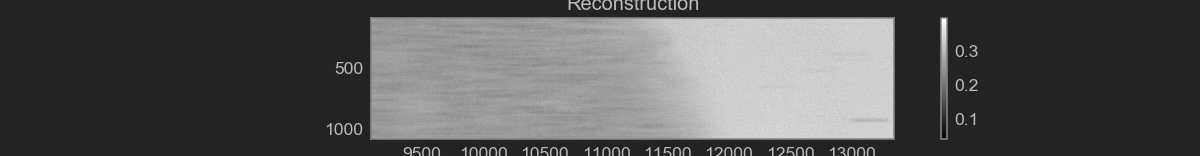

In [207]:
# recon.y_list = [y * frame_normalization_list_x[index][np.newaxis, :] * frame_normalization_list_y[index][:, np.newaxis] for (y, index) in zip(recon.y_list, recon.dataset.frame_mask)]

recon.reconstruct(iteration_count=-1, mode='static')
recon.show(figsize=(12,2))

<IPython.core.display.Javascript object>


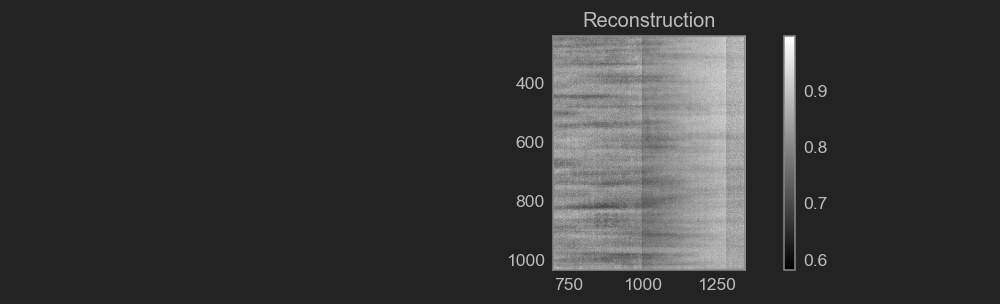

In [149]:
# recon.y_list = [y * frame_normalization_list_x[index][np.newaxis, :] * frame_normalization_list_y[index][:, np.newaxis] for (y, index) in zip(recon.y_list, recon.dataset.frame_mask)]

recon.reconstruct(iteration_count=-1, mode='static')
recon.show()

In [19]:
dataset.position_segment_indicies = dataset.position_segment_indicies_full

# measurement_list_normalized = [meas * norm for (meas, norm) in zip(dataset.frame_list, frame_normalization_list)]

measurement_list_normalized = []
for (meas, norm_y, norm_x) in zip(dataset.frame_list, frame_normalization_list_y, frame_normalization_list_x):
    meas = meas.copy()
    meas *= norm_y[:, np.newaxis]
    meas *= norm_x[np.newaxis, :]
    measurement_list_normalized.append(meas)

# Get blur kernels
path_info = md.blurkernel.blurVectorsFromDataset(dataset,
                                                 debug=False,
                                                 kernel_corrections={},
                                                 use_phase_ramp=False)
blur_vector_list, blur_vector_roi_list, frame_segment_list, position_list, illum_list = path_info

# Generate measurement ROIs
roi_list_measurements_full = []
for index, (blur_vector, blur_roi) in enumerate(zip(blur_vector_list, blur_vector_roi_list)):
    # Determine blur kernel shape
    blur_kernel_shape = [yp.next_even_number(yp.next_fast_len(sh_roi + sh)) for (sh_roi, sh) in zip(blur_roi.shape, dataset.frame_shape)]

    # Determine convolution support
    convolution_support_start = [kernel_start - sh // 2 for (kernel_start, sh) in zip(blur_roi.start, dataset.frame_shape)]

    # Generate ROI
    roi_list_measurements_full.append(yp.Roi(start=convolution_support_start, shape=dataset.frame_shape))
    
# Calculate segment direcitons
frame_segment_direction_list = []
segments_in_dataset = dataset.position_segment_indicies 
for segment_index in segments_in_dataset:
    frames_in_segment = [frame_index for frame_index in range(dataset.shape[0]) if frame_segment_list[frame_index] == segment_index]

    # Get first and last ROI in segment
    first_roi, last_roi = blur_vector_roi_list[frames_in_segment[0]], blur_vector_roi_list[frames_in_segment[-1]]

    # Append to list
    frame_segment_direction_list.append(last_roi.start[blur_axis] > first_roi.start[blur_axis])

# Apply frame offset (registration)
for index, roi in enumerate(roi_list_measurements_full):
    
    left_to_right_direction = frame_segment_direction_list[frame_segment_list[index]]
    delta = [0, 0]
    segment_index = len([segment for segment in frame_segment_list[:index] if segment == frame_segment_list[index]])
    delta[blur_axis] = segment_index * frame_dependent_offset
    if not left_to_right_direction:
        delta[blur_axis] *= -1
    roi -= delta
    
    delta = [0, 0]
    delta[blur_axis] = segment_dependent_offset
    if not left_to_right_direction:
        delta[blur_axis] *= -1
    roi -= delta

md.recon.alignRoiListToOrigin(roi_list_measurements_full)

<IPython.core.display.Javascript object>


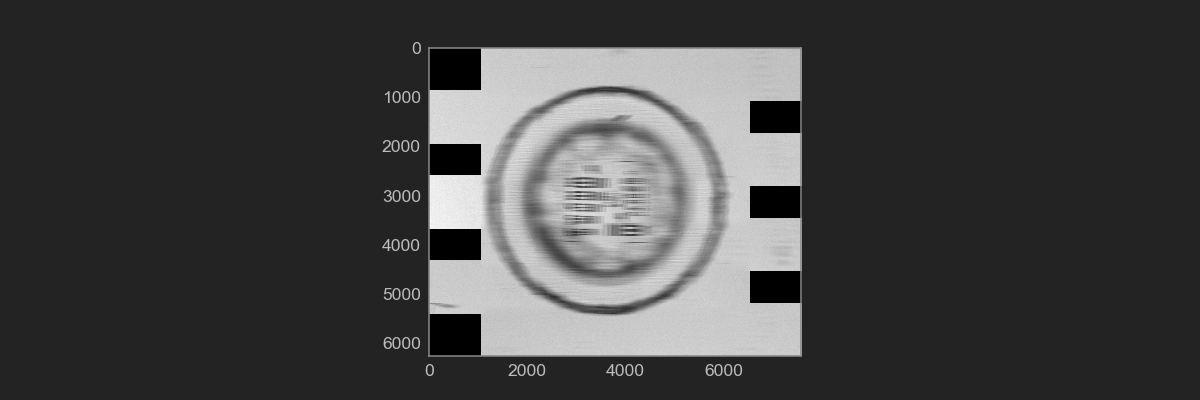

In [20]:
# Generate segmenetation Operator
G = ops.Segmentation(roi_list_measurements_full, roi_list_measurements_full[0].input_shape, alpha_blend_size=1000)

# Concatenate measurements
y = ops.VecStack(measurement_list_normalized)

# Perform reconstruction
stitched = G.inv * y

plt.figure()
plt.imshow(stitched)